# Adversarial Autoencoder

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on GPU


Let's load the MNIST data set.

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Create a *loader* to feed the data batch by batch during training.

In [4]:
batch = 200
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True, drop_last=True)

Now, we define the **autoencoder** as well as the **discriminator**.

In [5]:
z_dim = 3
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.encoder_top = nn.Sequential(
                            nn.Conv2d(1, 64, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.MaxPool2d(2), # (32, 14, 14)
                            nn.Conv2d(64, 64, 3), # (64, 12, 12)
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.MaxPool2d(2), # (64, 6, 6))
                            nn.Conv2d(64, 8, 3), # (8, 4, 4)
                            nn.ReLU(),
                            nn.BatchNorm2d(8))
        self.encoder_bottom = nn.Sequential(
                            nn.Linear(8 * 4 * 4, 128),
                            nn.ReLU(),
                            nn.Linear(128, z_dim))

    def forward(self, x):
        x = self.encoder_top(x)
        x = x.view(x.size(0), -1)
        return self.encoder_bottom(x)


class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.decoder_top = nn.Sequential(
                            nn.Linear(z_dim, 128),
                            nn.ReLU(),
                            nn.BatchNorm1d(128),
                            nn.Linear(128, 8 * 4 * 4),
                            nn.ReLU(),
                            nn.BatchNorm1d(8 * 4 * 4))
        self.decoder_bottom = nn.Sequential(
                            nn.Conv2d(8, 64, 3, padding=2), # (64, 6, 6)
                            nn.UpsamplingNearest2d(scale_factor=2), # (64, 12, 12)
                            nn.PReLU(64),
                            nn.BatchNorm2d(64),
                            nn.Conv2d(64, 64, 3, padding=2), # (32, 14, 14)
                            nn.PReLU(64),
                            nn.UpsamplingNearest2d(scale_factor=2), # (32, 28, 28)
                            nn.Conv2d(64, 1, 3, padding=1),
                            nn.Sigmoid()) # (1, 28, 28)

    def forward(self, x):
        x = self.decoder_top(x)
        x = x.view(x.size(0), 8, 4, 4)
        return self.decoder_bottom(x)    

    
# discriminator
discriminator = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.PReLU(128),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.PReLU(32),
            nn.Linear(32, 1),
            nn.Sigmoid()).type(FloatTensor)

encoder = Encoder(z_dim).type(FloatTensor)
decoder = Decoder(z_dim).type(FloatTensor)
autoencoder = nn.Sequential(encoder, decoder).type(FloatTensor)

We define the loss function and optimization schemes (here **Adam**) for the autoencoder and the discriminator.

In [6]:
lr = 0.001 # learning rate
criterion = nn.BCELoss()
optimizer_ae = torch.optim.Adam(params=autoencoder.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=0.005)
optimizer_g = torch.optim.Adam(params=encoder.parameters(), lr=lr)

Finally, we train the adversarial autoencoder.

In [7]:
epochs = 10
data_size = int(mnist.train_labels.size()[0])

for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        #images = images.view(batch, -1)
        images = Variable(images).type(FloatTensor)
        
        ones = Variable(torch.ones(images.size(0))).type(FloatTensor)
        zeros = Variable(torch.zeros(images.size(0))).type(FloatTensor)

        # Autoencoder step
        autoencoder.zero_grad()
        reconstructions = autoencoder(images)
        loss_ae = torch.dist(images, reconstructions) / reconstructions.size(0)
        loss_ae.backward()
        optimizer_ae.step()

        # Discriminator step
        discriminator.zero_grad()
        z_fake = encoder(images.detach())
        z_real = Variable(torch.randn(z_fake.size())).type(FloatTensor)
        z_fake_d = discriminator(z_fake)
        z_real_d = discriminator(z_real)

        loss_real = criterion(z_real_d, ones)
        loss_fake = criterion(z_fake_d, zeros)
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Generator (encoder) step
        encoder.zero_grad()
        z_fake = encoder(images)
        z_fake_d = discriminator(z_fake)
        loss_g = criterion(z_fake_d, ones)
        loss_g.backward()
        optimizer_g.step()
        if (j + 1) % 150 == 0:
            print('Epoch %i/%i [%i/%i] loss ae: %.4f, D(z_real)=%.2f, D(E(x))=%.2f' % (i + 1, epochs, j + 1,
                            data_size / float(batch), loss_ae.data[0], z_real_d.mean().data[0],
                            z_fake_d.mean().data[0]))

Epoch 1/10 [150/300] loss ae: 1.6132, D(z_real)=0.52, D(E(x))=0.49
Epoch 1/10 [300/300] loss ae: 1.6095, D(z_real)=0.47, D(E(x))=0.48
Epoch 2/10 [150/300] loss ae: 1.5866, D(z_real)=0.50, D(E(x))=0.50
Epoch 2/10 [300/300] loss ae: 1.5955, D(z_real)=0.49, D(E(x))=0.50
Epoch 3/10 [150/300] loss ae: 1.5733, D(z_real)=0.51, D(E(x))=0.49
Epoch 3/10 [300/300] loss ae: 1.5709, D(z_real)=0.50, D(E(x))=0.50
Epoch 4/10 [150/300] loss ae: 1.5410, D(z_real)=0.49, D(E(x))=0.50
Epoch 4/10 [300/300] loss ae: 1.5230, D(z_real)=0.51, D(E(x))=0.49
Epoch 5/10 [150/300] loss ae: 1.5513, D(z_real)=0.50, D(E(x))=0.51
Epoch 5/10 [300/300] loss ae: 1.5344, D(z_real)=0.50, D(E(x))=0.50
Epoch 6/10 [150/300] loss ae: 1.5454, D(z_real)=0.50, D(E(x))=0.50
Epoch 6/10 [300/300] loss ae: 1.5262, D(z_real)=0.50, D(E(x))=0.50
Epoch 7/10 [150/300] loss ae: 1.5361, D(z_real)=0.50, D(E(x))=0.50
Epoch 7/10 [300/300] loss ae: 1.5233, D(z_real)=0.50, D(E(x))=0.50
Epoch 8/10 [150/300] loss ae: 1.5466, D(z_real)=0.50, D(E(x))=

Let's plot some images along their reconstructions.

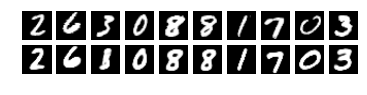

In [8]:
images = images.view(batch, 28, 28).data.cpu().numpy()
reconstructions = reconstructions.view(batch, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(6, 6))
for i in range(10):
    a = fig.add_subplot(10, 10, i + 1)
    b = fig.add_subplot(10, 10, i + 11)
    a.axis('off')
    b.axis('off')
    image = images[i - 1]
    reconstruction = reconstructions[i - 1]
    a.imshow(image, cmap='Greys_r')
    b.imshow(reconstruction, cmap='Greys_r');

The low-dimensional representation is supposed to follow a standard Gaussian distribution. Let's check it!

In [9]:
n_samples = 10000
data_loader.batch_size = n_samples
images, labels = next(data_loader.__iter__())
images = Variable(images)
code = encoder(images.type(FloatTensor))

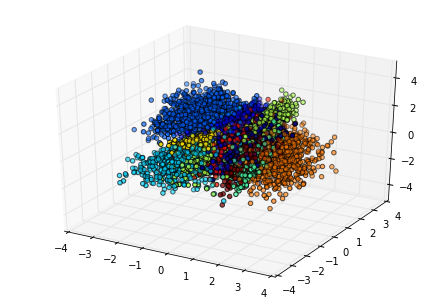

In [11]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(*zip(*code.data.cpu().numpy()[:, :3]), c=labels.numpy());